In [116]:
import random
import numpy as np
import pandas as pd
import json
import cv2
import os
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torchvision
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
import torch
from PIL import Image

from pipeline.metrics import accuracy_b, log_loss
from pipeline.model_methods import validate_img, train_img, validate_vid, train_vid
from pipeline.data_loaders import load_img_dataset, load_img_val_dataset
from pipeline.image_extracting import extract_faces, FastMTCNN

from pipeline.metrics import accuracy_sigmoid, accuracy_sigmoid_mean, log_loss_sigmoid, log_loss_b, accuracy_b_mean
from pipeline.model_methods import validate_vid_bf, train_vid_bf
from pipeline.image_extracting import crop_faces, FastMTCNN, InceptionResnetV1, extract_faces_dlib, MTCNN
from pipeline.blazeface import BlazeFace
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, ImageCompression, Resize, RandomScale, RandomFog, RandomShadow, Downscale, JpegCompression, CenterCrop,
    RandomGamma, RandomContrast, Cutout, RandomCrop, Normalize, Cutout, RandomFog,Posterize,FancyPCA
)


random.seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ImportError: cannot import name 'FancyPCA'

In [115]:
def strong_aug(p=1):
    return Compose([
        JpegCompression(quality_lower=8, quality_upper=30, p=1),
        OneOf([IAAAdditiveGaussianNoise(p=1), GaussNoise(p=1)], p=1),
        OneOf([CLAHE(clip_limit=2,p=1), IAASharpen(p=1), IAAEmboss(p=1)], p=1),
        RandomGamma(p=1),
        RandomBrightnessContrast(p=1),
        OneOf([MotionBlur(blur_limit=5,p=1),MedianBlur(blur_limit=5, p=1),Blur(blur_limit=5, p=1)], p=1),
        OpticalDistortion(p=1),
        HueSaturationValue(hue_shift_limit=10, p=1),
        RandomRotate90(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(p=1),
        Cutout(p=1),
        RandomFog(p=1),
        Posterize(p=1),
        FancyPCA(p=1)
    ], p=p)


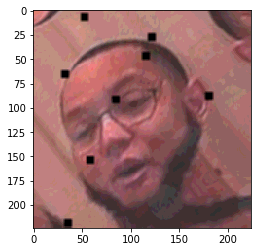

In [114]:
from albumentations import CoarseDropout
path = r'C:\Users\user\Desktop\Projects\dfdc-kaggle-solution\data\train\fake\aabmgfhcgg.jpg' if True else r'C:\Users\user\Desktop\Projects\dfdc-kaggle-solution\data\train\real\00000.png'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img = CenterCrop(224,224)(image=img)['image']
img = strong_aug()(image=img)['image']
img = Resize(224,224)(image=img)['image']
plt.imshow(img)
plt.show()

In [2]:
facedet = BlazeFace().to(device)
facedet.load_weights("pipeline/blazeface.pth")
facedet.load_anchors("pipeline/anchors.npy")
_ = facedet.train(False)

from pipeline.helpers.read_video_1 import VideoReader
from pipeline.helpers.face_extract_1 import FaceExtractor

frames_per_video = 1

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [4]:
y_train = pd.read_csv(r'D:\Machine Learning\deepfake-detection\data\frames\metadata.csv')

In [61]:
js = {}
with open(r'D:\Machine Learning\deepfake-detection\data\train_sets\dfdc_train_part_40\metadata.json', 'r') as r:
    js = json.loads(r.read())

In [62]:
len([i for i in js if js[i]['label'] == 'FAKE']), len([i for i in js if js[i]['label'] == 'REAL'])

(1965, 455)

In [63]:
path_val = r'data\val'
path_fake = r'data\train\fake'
path_real = r'data\train\real'

val = [i.split('.')[0] for i in os.listdir(path_val)]
fake = [i.split('.')[0] for i in os.listdir(path_fake)]
real = [i.split('.')[0] for i in os.listdir(path_real)]

In [64]:
j = 0
for i in js:
    fname = i.split('.')[0]
    try:
        if fname in fake:
            os.rename('data\\train\\fake\\' + fname + '.jpg', 'data\\img_val\\fake\\' + fname + '.jpg')
            j += 1

        if fname in real:
            os.rename('data\\train\\real\\' + fname + '.jpg', 'data\\img_val\\real\\' + fname + '.jpg')
            j += 1
    except FileNotFoundError:
        pass
print(j)

2301


In [ ]:
for i in js:
    os.rename('')

In [10]:
removed = 0
for file in val:
    if file in fake:
        os.remove(path_fake + '\\' + file + '.jpg')
        removed += 1
        
    if file in real:
        os.remove(path_real + '\\' + file + '.jpg')
        removed += 1
        
print('Removed', removed)

Removed 0


In [5]:
DATA_PATH = r'D:\Machine Learning\deepfake-detection\data\all_vids'
OUTPUT_PATH = r'D:\Machine Learning\deepfake-detection\data\frames'
files = os.listdir(DATA_PATH)

for i in tqdm.tqdm_notebook(range(len(files))):
    original_name = files[i].split('.')[0]
    y = y_train[y_train.name == original_name].label.values[0]
    filename = DATA_PATH + '\\' + files[i]
    label = 'fake' if y else 'real'
    
    faces = crop_faces(filename, face_extractor, batch_size=frames_per_video, input_size=256)
    
    if faces is not None:
        img = Image.fromarray(faces)
        img.save(OUTPUT_PATH + '\\' + label + '\\' + original_name + '.jpg')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\mlkcecxwoe.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\mqbayostmj.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\qikdhhjwlj.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\qyeunoykln.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\rwtdszgykp.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\rxxqsjrmno.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\ryspsmtomm.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detecti

Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\snsrdzneby.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\snwvzbrgvg.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\sobgfhhcam.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\soellqnrep.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\soipgztqut.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\solncvzbgn.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detection\data\all_vids\sowuyjudky.mp4: need at least one array to concatenate
Prediction error on video D:\Machine Learning\deepfake-detecti

In [13]:
y0 = torch.tensor([0]*2000 + [1]*2000)
y = torch.FloatTensor([0.1]*2400 + [0.9]*1600)
log_loss_b(y, y0), 0.6931

(0.3250797688961029, 0.6931)

In [12]:
3600 / 4000

0.9

In [2]:
y_train = pd.read_csv('data\\metadata2.csv')

In [5]:
len(y_train[y_train.label == 'REAL']), len(y_train[y_train.label == 'FAKE'])

(16293, 79341)

In [3]:
y_train.head()

,videoname,original_width,original_height,label,original
0,gcpjokmohj.mp4,129,129,REAL,NaN
1,cxqhrnxgvd.mp4,185,186,FAKE,jwbsicnbyc.mp4
2,boxfdbfgsn.mp4,186,185,FAKE,jcfhtypqnv.mp4
3,rxfawebswj.mp4,267,267,FAKE,mtpvrsdblr.mp4
4,jmrfbhqnqk.mp4,185,185,REAL,NaN


In [8]:
real = 0
fake = 0
limit = 15000

DATA_PATH = 'data\\faces_155'

files = os.listdir(DATA_PATH)
for i in tqdm.tqdm_notebook(range(len(files))):
    y = int(y_train[y_train.videoname == files[i].split('.')[0]+'.mp4'].label.values[0] == 'FAKE')
    if real < limit and y == 0:
        os.rename(DATA_PATH + '\\' + files[i], 'data\\train\\real\\' + files[i])
        real += 1
    if fake < limit and y == 1:
        os.rename(DATA_PATH + '\\' + files[i], 'data\\train\\fake\\' + files[i])
        fake += 1

    if fake == limit and real == 0:
        print('STOP')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


In [ ]:
y_train[y_train.name == 'owxbbpjpch'].label.values[0]

In [ ]:
def extract_first_frame(video_path, frames_path, y_train):
    filename = video_path.split('\\')[-1].split('.')[0]
    y = y_train[y_train.name == filename].label.values[0]
    if y == 1:
        pth = frames_path + filename + '.jpg'
        vidcap = cv2.VideoCapture(video_path)
        success,image = vidcap.read()
        cv2.imwrite(pth, cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) )  # save frame as JPEG file
    else:
        vidcap = cv2.VideoCapture(video_path)
        for i in range(5):
            pth = frames_path + filename + "." + str(i) + '.jpg'
            success,image = vidcap.read()
            cv2.imwrite(pth, cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) )  # save frame as JPEG file

In [ ]:
%%time
'''Extract first frame from each test video'''
DATA_PATH = 'data\\test_videos'
FRAMES_PATH = 'data\\test_videos_img\\img\\'
for file in os.listdir(DATA_PATH):
    if file != 'metadata.json':
        extract_first_frame(DATA_PATH + '\\' + file, FRAMES_PATH)

In [ ]:
%%time
'''Extract first frame from each train video'''
for j in tqdm.tqdm_notebook(range(17, 18)):
    DATA_PATH = 'data\\train_sets\\dfdc_train_part_' + str(j)
    FRAMES_PATH = 'data\\frames\\dfdc_train_part_'+str(j)+'_img\\'
    files = os.listdir(DATA_PATH)
    for i in tqdm.tqdm_notebook(range(len(files))):
        if files[i] != 'metadata.json':
            extract_first_frame(DATA_PATH + '\\' + files[i], FRAMES_PATH, y_train)

In [ ]:
%%time

'''Gather metadata'''

FRAMES_PATH = 'data\\frames\\metadata.csv'
y_data = 'name,label'
for i in tqdm.tqdm_notebook(range(0, 18)):
    DATA_PATH = 'data\\train_sets\\dfdc_train_part_' + str(i)
    for file in os.listdir(DATA_PATH):
        if file == 'metadata.json':
            with open(DATA_PATH + '\\' + file) as r:
                parsed = json.loads(r.read())
                for name in parsed:
                    y_data += '\n' + name.split('.')[0] + ',' + str(int(parsed[name]['label'] == 'FAKE'))
with open(FRAMES_PATH, 'w') as w: 
    w.write(y_data)